In [1]:
import pandas as pd


In [2]:
health_df = pd.read_csv("data/interim/health.csv")


In [3]:
# Extract metadata
abstracts = health_df["objective"].to_numpy()
titles = health_df["title"].to_numpy()


In [4]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer("NovaSearch/stella_en_400M_v5", trust_remote_code=True)
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)


Some weights of the model checkpoint at NovaSearch/stella_en_400M_v5 were not used when initializing NewModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

In [5]:
embeddings.shape


(3508, 1024)

In [6]:
from umap import UMAP

# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(
    n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42
    )
reduced_embeddings = umap_model.fit_transform(embeddings)


/cluster/processing/climate_llm/learn/Modern-Analytics/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/processing/climate_llm/learn/Modern-Analytics/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/cluster/processing/climate_llm/learn/Modern-Analytics/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [7]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=30, metric="euclidean", cluster_selection_method="eom"
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))


/cluster/processing/climate_llm/learn/Modern-Analytics/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/processing/climate_llm/learn/Modern-Analytics/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


19

In [8]:
import numpy as np
# Print first three documents in cluster 0
cluster = 0

for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")
    

Non-alcoholic fatty liver disease (NAFLD) has a global prevalence of nearly 25% i.e., affects one quarter of the adult population. Early phase NAFLD is reversible and can be treated, but it may progress towards life-threatening stages such as non-alcoholic steatohepatitis (NASH), cirrhosis, and hepa... 

Non-alcoholic fatty liver disease (NAFLD) is a multifactorial chronic inflammatory disease that is prevalent in 1 of 4 individuals with a significant personal, socioeconomic and healthcare burden, especially at the later, more severe inflammatory stage of disease - non-alcoholic steatohepatitis (NAS... 

The ARTEMIs project aims to consolidate existing computational mechanistic and machine-learning models at different scales to deliver virtual twins embedded in a clinical decision support system (CDSS).  The CDSS will provide clinically meaningful information to clinicians, for a more personalised m... 



(2548, 4)
(960, 4)


(np.float64(2.3646576046943664),
 np.float64(11.670393025875091),
 np.float64(1.9950186491012574),
 np.float64(11.680376839637756))

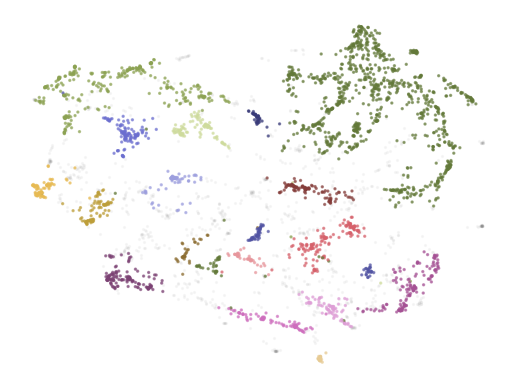

In [17]:
# Check clusters
import pandas as pd
import matplotlib.pyplot as plt

# Reduce 384-dimensional embeddings to two dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
to_plot = df.loc[df.cluster != "-1", :]
outliers = df.loc[df.cluster == "-1", :]

print(to_plot.shape)
print(outliers.shape)

# Plot outliers and non-outliers separately
plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey")
plt.scatter(to_plot.x, to_plot.y, c=to_plot.cluster.astype(int),
            alpha=0.6, s=2, cmap="tab20b"
)
plt.axis("off")


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))


In [11]:
# import spacy.cli
# spacy.cli.download("en_core_web_sm")


In [12]:
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# Flan-t5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
# Update our topic representations using Flan-T5
generator = pipeline("text2text-generation", model="google/flan-t5-small")
flant5_model = TextGeneration(
    generator, prompt=prompt, doc_length=350, tokenizer="whitespace"
)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "Flan-t5": flant5_model,
    "MMR": mmr_model,
    "POS": pos_model
}


Device set to use cuda:0


In [13]:
from bertopic import BERTopic

# Train our model with our previously defined models
# topic_model = BERTopic(
#     embedding_model=embedding_model,
#     umap_model=umap_model,
#     hdbscan_model=hdbscan_model,
#     verbose=True
# ).fit(abstracts, embeddings)

topic_model = BERTopic(
  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

topics, probs = topic_model.fit_transform(abstracts, embeddings)


2025-05-21 05:20:02,127 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-21 05:20:24,921 - BERTopic - Dimensionality - Completed ✓
2025-05-21 05:20:24,923 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-21 05:20:24,993 - BERTopic - Cluster - Completed ✓
2025-05-21 05:20:24,997 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 19/19 [00:02<00:00,  7.23it/s]
2025-05-21 05:20:43,525 - BERTopic - Representation - Completed ✓


In [14]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,KeyBERT,Flan-t5,MMR,POS,Representative_Docs
0,-1,960,-1_health_research_project_new,"[health, research, project, new, based, data, ...","[ai, diseases, approaches, aims, clinical, dis...","[SMILE, , , , , , , , , ]","[health, research, project, new, data, brain, ...","[health, research, project, new, data, develop...",[AI4Lungs will develop and validate novel AI-b...
1,0,981,0_cancer_cell_cells_tumor,"[cancer, cell, cells, tumor, treatment, patien...","[cancer cells, tumors, metastatic, tumour, can...","[IPSIRIUS, , , , , , , , , ]","[cancer, cells, patients, project, immune, res...","[cancer, cell, cells, tumor, treatment, patien...",[Novel cancer molecular-targeted therapies all...
2,1,289,1_viral_virus_vaccine_malaria,"[viral, virus, vaccine, malaria, viruses, infe...","[sars cov, sars, covid 19, viruses, antiviral,...",[Virus: Virus: Virus: Virus: Virus: Virus: Vir...,"[vaccine, malaria, viruses, immune, vaccines, ...","[viral, virus, vaccine, malaria, viruses, infe...",[Lower respiratory tract infections resulting ...
3,2,138,2_ad_disease_brain_dementia,"[ad, disease, brain, dementia, tau, protein, m...","[microglia, neuroinflammation, neurodegenerati...",[human microglia transduce toxicity to neurons...,"[dementia, microglia, neurodegenerative, alzhe...","[disease, brain, dementia, protein, neurodegen...",[The recently approved drugs for Alzheimers di...
4,3,136,3_heart_cardiac_patients_clinical,"[heart, cardiac, patients, clinical, cardiovas...","[cardiomyocytes, myocardial, cardiac, cardiova...","[novel bioprinting for cardiac fibrosis, , , ,...","[heart, cardiac, patients, cardiovascular, str...","[heart, cardiac, patients, clinical, cardiovas...",[Cardiovascular diseases (CVDs) are the leadin...
5,4,130,4_social_political_health_pandemic,"[social, political, health, pandemic, project,...","[eu, europe, european, crises, 19 pandemic, pa...","[REGROUP: resiliency, , , , , , , , , ]","[social, project, research, policy, covid, wom...","[social, political, health, pandemic, project,...",[RECOVER-GEU presents an innovative gendered p...
6,5,111,5_antibiotics_resistance_antibiotic_antimicrobial,"[antibiotics, resistance, antibiotic, antimicr...","[antimicrobial resistance, antibiotic resistan...","[Antimicrobial resistance, , , , , , , , , ]","[antibiotics, antibiotic, antimicrobial, bacte...","[antibiotics, resistance, antibiotic, antimicr...",[The emergence of Gram-negative bacterial resi...
7,6,102,6_bone_tissue_pain_oa,"[bone, tissue, pain, oa, mechanical, implants,...","[bone regeneration, bioprinting, tissue engine...","[BioForceInk: bioactive reinforcing bioink, , ...","[bone, tissue, oa, implants, bioprinting, cart...","[bone, tissue, pain, mechanical, implants, bio...",[Bone fracture nonunion (FNU) is one of the le...
8,7,90,7_gut_ibd_microbiota_intestinal,"[gut, ibd, microbiota, intestinal, microbiome,...","[gut microbiome, gut microbiota, microbiome, m...","[Inflammatory Bowel Disease, , , , , , , , , ]","[gut, ibd, microbiota, intestinal, microbiome,...","[gut, microbiota, intestinal, microbiome, host...","[The human gut microbiota, the trillions of mi..."
9,8,83,8_food_sustainable_protein_production,"[food, sustainable, protein, production, food ...","[food systems, sustainable food, food security...","[INCiTiS-FOOD, , , , , , , , , ]","[food, sustainable, protein, food systems, nut...","[food, sustainable, protein, production, nutri...",[The agri-food industry faces numerous challen...


In [19]:
# To get all representations for a single topic
topic_model.get_topic(8, full=True)


{'Main': [('food', np.float64(0.08473403490676748)),
  ('sustainable', np.float64(0.027949629021064768)),
  ('protein', np.float64(0.018075719982218113)),
  ('production', np.float64(0.01690755088719185)),
  ('food systems', np.float64(0.015579310061626604)),
  ('nutrition', np.float64(0.015227458081535732)),
  ('based', np.float64(0.014701919524318628)),
  ('products', np.float64(0.014508949316945914)),
  ('diets', np.float64(0.014358702139202612)),
  ('plant', np.float64(0.014346323478308724))],
 'KeyBERT': [('food systems', np.float32(0.6771498)),
  ('sustainable food', np.float32(0.63270825)),
  ('food security', np.float32(0.6211364)),
  ('agri food', np.float32(0.588652)),
  ('food safety', np.float32(0.53301615)),
  ('healthy sustainable', np.float32(0.521467)),
  ('foods', np.float32(0.50952613)),
  ('agri', np.float32(0.50917566)),
  ('food', np.float32(0.5028857)),
  ('sustainability', np.float32(0.48213464))],
 'Flan-t5': [('INCiTiS-FOOD', 1),
  ('', 0),
  ('', 0),
  ('', 0)

In [20]:
# or use one of the other topic representations, like KeyBERTInspired
keybert_topic_labels = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in topic_model.topic_aspects_["KeyBERT"].items()}
topic_model.set_topic_labels(keybert_topic_labels)


In [22]:
# `topic_distr` contains the distribution of topics in each document
topic_distr, _ = topic_model.approximate_distribution(abstracts, window=8, stride=4)


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


In [23]:
abstract_id = 10
print(abstracts[abstract_id])


BiomimX Beating organs-on-chips (OoC) are in vitro miniaturized and living replica of human organs and diseases,building upon cutting-edge technologies and human cells. Beating OoC provide a faithful replication of native humanphysiology integrating miniaturized 3D cell culture techniques, mechanical stimulation (uBeat®) and electrical recordingcapabilities (uSense). BiomimX’s proprietary key technology (uBeat®) supports 3D human cell cultures and integrates acontrolled and tunable mechanical stimulation system. uBeat® leads to the generation of mature and functional miniaturizedreplication of human organs adequate to test compounds toxicity/functionality in a high-throughput fashion. Integration ofuSense allows real-time evaluation of clinically relevant parameters from the established beating models. BiomimX’sBeating OoC represent a safer, more efficient and faster alternative to poorly predictable preclinical models to date available inthe drug discovery pipeline (DDP). BiomimX alre

In [24]:
# Visualize the topic-document distribution for a single document
topic_model.visualize_distribution(topic_distr[abstract_id])


In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))


In [ ]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()


In [ ]:
# Visualize relationships between topics
# topic_model.visualize_heatmap(n_clusters=30)


In [ ]:
# Visualize the potential hierarchical structure of topics
# topic_model.visualize_hierarchy()


In [ ]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)


In [ ]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):
        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]
    return df


In [ ]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)
# Show topic differences
topic_differences(topic_model, original_topics)


In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(30)),
    reduced_embeddings=reduced_embeddings,
    width=1200
)
fig


In [ ]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.2)
topic_model.update_topics(abstracts, representation_model=representation_model)
# Show topic differences
topic_differences(topic_model, original_topics)

# Topic representations


In [ ]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: '[KEYWORDS]'.
Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline("text2text-generation", model="google/flan-t5-small")
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)

topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)
